In [6]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd

In [7]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [8]:
%%cython
cimport numpy as np
import numpy as np
import scipy as sp
import pickle
from numpy.random import uniform, normal, beta, exponential

# hyperparameters
D_min = 0.001
D_max = 2
unit_T = 0.1 # s
unit_L = 0.167 # um

def prior_nonuniform(int nstates, int order):
    cdef np.ndarray[np.double_t, ndim = 2] alpha
    cdef int row, col
    
    if order < nstates:
        return uniform(D_min, D_max)
    else:
        alpha = np.ones((nstates, nstates)) * (1 + 0.5 / (nstates - 1))
        alpha[range(nstates), range(nstates)] = 10.5
        row = (int)((order - nstates) / nstates)
        col = order % nstates
        return beta(alpha[row, col], alpha[row + 1:, col].sum())

def convert_theta(np.ndarray[np.double_t, ndim = 1] theta, int nstates):
    cdef np.ndarray[np.double_t, ndim = 2] sigma, P
    cdef int i, j
    
    # diffusivity to sigma
    sigma = np.sqrt(2 * theta[:nstates] * unit_T)[:, None]
    P = np.ones((nstates, nstates), dtype = float)
    # to transition probability

    if nstates == 1 :
        return sigma, P
    else:
        for i in range(nstates - 1):  # row
            for j in range(nstates):  # column
                if i == 0: #first row
                    P[i, j] = theta[nstates + j]
                elif i == 1:
                    P[i, j] = (1 - P[i-1, j]) * theta[nstates*2 + j]
                elif i == 2:
                    P[i, j] = (1 - P[i-1, j] - P[i-2, j]) * theta[nstates*3 + j]
        P[nstates - 1, :] = 1 - P[:nstates - 1, :].sum(axis = 0)
        return sigma, P
    
def hmm_p_ini(np.ndarray[np.double_t, ndim = 2] P, int nstates): ##P : transition probability, p_ij : prob. from j to i
    cdef np.ndarray[np.double_t, ndim = 2] p_ini
    cdef np.ndarray[np.double_t, ndim = 1] eig_val
    cdef np.ndarray[np.double_t, ndim = 2] eig_vec
    
    eig_val = np.real(np.linalg.eig(P)[0])
    eig_vec = np.real(np.linalg.eig(P)[1])
    p_ini = eig_vec[:, abs(eig_val - 1) < 0.0000001] / (eig_vec[:, abs(eig_val - 1) < 0.0000001]).sum()
    return p_ini #column vector

def hmm_emission(np.ndarray[np.double_t, ndim = 1] obs,
                 np.ndarray[np.double_t, ndim = 2] sigma):
    return -np.log(2*np.pi*(sigma**2))/2 - (obs**2)/(2*(sigma**2))

def logsumexpcol(np.ndarray[np.double_t, ndim = 2] x):
    cdef np.ndarray[np.double_t] y, z
    y = np.max(x, axis = 0)
    x = x - y
    z = y + np.log((np.exp(x)).sum(0))
    z[y[:]==-np.inf] = -np.inf
    return z

def forward(np.ndarray[np.double_t, ndim = 2] obs,
            np.ndarray[np.double_t, ndim = 2] P,
            np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
            int nstates):
    cdef np.ndarray[np.double_t, ndim = 2] pstate_ini, logPT, aprev, a  #pstate_ini : column vector
    cdef np.ndarray[np.double_t, ndim = 1] obs_cur # value
    cdef int i
    
    pstate_ini = hmm_p_ini(P, nstates).copy() #initial distribution
#    pstate_ini = np.ones(nstates, dtype = float)[:, None] / nstates #uniform initial distribution
    
    logPT = np.log(P.T).copy()
    aprev = np.log(pstate_ini).copy()
    a = np.zeros((nstates, obs.shape[0]))
    
    for i in range(obs.shape[0]):
        obs_cur = obs[i].copy()
        a[:, i][:, None] = hmm_emission(obs_cur, sigma) + aprev  #log alpha(time), column vector
        aprev = logsumexpcol(logPT + a[:, i][:, None])[:, None]

    return a, logsumexpcol(a[:, obs.shape[0]-1][:, None])  #log alpha and log likelihood

def backward(np.ndarray[np.double_t, ndim = 2] obs,
             np.ndarray[np.double_t, ndim = 2] P,
             np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
             int nstates):
    
    cdef np.ndarray[np.double_t, ndim = 2] logP, b
    cdef np.ndarray[np.double_t, ndim = 1] obs_cur
    cdef int i, trjlen
    
    logP = np.log(P).copy()
    b = np.zeros((nstates, obs.shape[0]))
    
    trjlen = obs.shape[0]
    for i in range(1, trjlen):
        obs_cur = obs[trjlen - i].copy()
        b[:, trjlen - i - 1][:, None] = logsumexpcol(logP + b[:, trjlen - i][:, None] + hmm_emission(obs_cur, sigma))[:, None]
    
    return b

#update gamma and xi
def gamma_probs(np.ndarray[np.double_t, ndim = 2] obs,
                np.ndarray[np.double_t, ndim = 2] P,
                np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
                
                np.ndarray[np.double_t, ndim = 2] a,
                np.ndarray[np.double_t, ndim = 2] b,
                double logL,
                int nstates):
    
    cdef np.ndarray[np.double_t, ndim = 2] gamma
    cdef int i, j
    
    gamma = np.zeros((nstates, obs.shape[0]))
    for i in range(obs.shape[0]):
        gamma[:, i] = a[:, i] + b[:, i] - logL
        
    return np.exp(gamma)

def gamma_est(np.ndarray[np.double_t, ndim = 2] obs,
              np.ndarray[np.double_t, ndim = 2] P,
              np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
              int nstates):
    
    cdef np.ndarray[np.double_t, ndim = 2] gamma, a, b
    cdef double logL
    cdef int i, j
    
    a, logL = forward(obs, P, sigma, nstates)  #log alpha, log L
    b = backward(obs, P, sigma, nstates)  #log beta
    
    gamma = np.zeros((nstates, obs.shape[0]))
    for i in range(obs.shape[0]):
        gamma[:, i] = a[:, i] + b[:, i] - logL
        
    return np.exp(gamma)

def xi_probs(np.ndarray[np.double_t, ndim = 2] obs,
             np.ndarray[np.double_t, ndim = 2] P,
             np.ndarray[np.double_t, ndim = 2] sigma, #sigma : column vector
             
             np.ndarray[np.double_t, ndim = 2] a,
             np.ndarray[np.double_t, ndim = 2] b,
             double logL,
             int nstates):
    
    cdef np.ndarray[np.double_t, ndim = 3] xi
    cdef np.ndarray[np.double_t, ndim = 2] logP
    cdef np.ndarray[np.double_t, ndim = 1] obs_cur
    cdef int t
    
    xi = np.zeros((obs.shape[0] - 1, nstates, nstates))   #log xi
    logPT = np.log(P.T).copy()
    
    for t in range(obs.shape[0] - 1):
        obs_cur = obs[t + 1].copy()
        xi[t] = (a[:, t][:, None] + logPT +  (b[:, t + 1][:, None] + hmm_emission(obs_cur, sigma))[:, 0] - logL).T
    
    return np.exp(xi)

def baum_welch(np.ndarray[np.double_t, ndim = 2] obs, #obs[t] : v(t), time * dimension
               np.ndarray[np.double_t, ndim = 1] D,
               int nstates,
               int iteration,
               double stop_logratio = 0.00000001,
               int max_cnt = 1000,
               int seed = 1):
    cdef np.ndarray[np.double_t, ndim = 3] xi
    cdef np.ndarray[np.double_t, ndim = 2] gamma
    cdef np.ndarray[np.double_t, ndim = 2] a, b, tempa
    cdef np.ndarray[np.double_t, ndim = 1] params
    cdef np.ndarray[np.double_t, ndim = 2] sigma, P, opt_P, opt_sigma
    cdef double logL, opt_logL, new_logL
    cdef double logratio
    cdef int i, j, nparams, cnt
    
    nparams = nstates ** 2
    params = np.zeros(nparams)
    opt_params = np.zeros(nparams)
    opt_logL = -np.inf

    np.random.seed(seed)
    
    for i in range(iteration):  #run baum-welch with different initial paramters
        print('iter:', i)
        #setting initial parameters from prior distribution
        for j in range(nparams):
#            params[j] = prior_jeffrey(nstates, j)
            params[j] = prior_nonuniform(nstates, j)
        print('D:', D)
        params[:nstates] = D.copy() ## fixed diffusivity
        sigma, P = convert_theta(params[:nparams], nstates)
        
        print('sigma:', sigma)
        print('P:', P)
        
        a, logL = forward(obs, P, sigma, nstates)  #log alpha, log L
        b = backward(obs, P, sigma, nstates)  #log beta
        
        cnt = 0
        while(1):
            xi = xi_probs(obs, P, sigma, a, b, logL, nstates)
            gamma = gamma_probs(obs, P, sigma, a, b, logL, nstates)
            
            #P = np.sum(xi, axis = 0) / np.sum(gamma[:, :obs.shape[0] - 1], axis = 1)
            P = np.sum(xi, axis = 0) / np.sum(np.sum(xi, axis = 0), axis = 0) #P update
            #sigma = np.sqrt(np.sum(gamma * (obs ** 2)[:, 0], axis = 1)/ np.sum(gamma, axis = 1))[:, None]
            
            a, new_logL = forward(obs, P, sigma, nstates)
            b = backward(obs, P, sigma, nstates)
            
            logratio = new_logL - logL
            logL = new_logL
            
            if logratio < stop_logratio or cnt > max_cnt:
                if opt_logL < logL:
                    opt_logL = logL
                    opt_P = P
                    opt_sigma = sigma
                break
            cnt += 1
        print(opt_P)
    return opt_P


def baum_skel_for_P(np.ndarray[np.double_t, ndim = 2] obs,
                    np.ndarray[np.double_t, ndim = 1] D,
                    int nstates,
                    int iteration,
                    double stop_logratio = 0.00001,
                    int max_cnt = 100,
                    int seed = 1):

    cdef int i, j
    cdef np.ndarray[np.double_t, ndim = 2] opt_D, opt_P
    cdef double opt_logL

    print('nstate:', nstates)
    opt_P = baum_welch(obs, D, nstates, iteration, max_cnt = max_cnt)
    
    return opt_P

def viterbi(np.ndarray[np.double_t, ndim = 2] obs, # column vector
            np.ndarray[np.double_t, ndim = 2] P, # (optimal) transition matrix
            np.ndarray[np.double_t, ndim = 2] sigma, # (optimal) sigmas, column vector
            int nstates
           ):
    
    cdef np.ndarray[np.double_t, ndim = 2] T1
    cdef np.ndarray[np.int_t, ndim = 2] T2
    cdef np.ndarray[np.double_t, ndim = 2] pi # initial distribution, column vector
    cdef np.ndarray[np.double_t, ndim = 2] pstate_ini #
    cdef np.ndarray[np.int_t, ndim = 1] X # optimal sequence
    cdef int i, j, T
    
    
    T = np.shape(obs)[0]
    pi = np.log(hmm_p_ini(P, nstates))  # log initial probability
    
    T1 = np.zeros((nstates, T))  # nstates * trjlen
    T2 = np.zeros((nstates, T), dtype = int)  # log zero
    
    T1[:, 0] = pi[:, 0] + hmm_emission(obs[0], sigma)[:, 0]  # log
    for i in range(1, T):
        T1[:, i] = hmm_emission(obs[i], sigma)[:, 0] + np.max(np.log(P) + np.array([T1[:, i-1],] * nstates), axis = 1)
        T2[:, i] = np.argmax(np.log(P) + np.array([T1[:, i-1],] * nstates), axis = 1)
    
    X = np.zeros(T, dtype = int)
    X[T-1] = np.argmax(T1[:, T-1])

    for i in range(1, T):
        X[T-(i+1)] = T2[X[T-i], T-i]

    return X

def dp_to_theta(np.ndarray[np.double_t, ndim = 1] D, np.ndarray[np.double_t, ndim = 2] P, int nstates):
    cdef int i, j
    cdef np.ndarray[np.double_t, ndim = 1] theta
    
    theta = np.zeros(nstates ** 2)
    theta[:nstates] = D.copy()
    
    if nstates != 1:
        for i in range(nstates - 1):
            for j in range(nstates):
                if i == 0:
                    theta[nstates * (i + 1) + j] = P[i, j]
                elif i == 1:
                    theta[nstates * (i + 1) + j] = P[i, j] / (1 - P[i-1, j])
                elif i == 2:
                    theta[nstates * (i + 1) + j] = P[i, j] / (1 - P[i-1, j] - P[i-2, j])
    return theta

In [13]:
#MSH
unit_T = 0.1
d_aicmle = np.array([0.00446527, 0.06048195, 0.35995965])
d_aicmap = np.array([0.00594333, 0.06448872, 0.35193424])
d_baymle = np.array([0.00531209, 0.0667621, 0.39093717])
d_baymap = np.array([0.00401332, 0.07041428, 0.42212455])

d_avg = (d_aicmle + d_aicmap + d_baymle + d_baymap) / 4

sigma = np.sqrt(2 * d_avg * unit_T)[:, None]
widths = np.sqrt(2 * d_avg * unit_T)

In [10]:
#data

path = ['MSH2/5nM', 'MSH2/10nM']
protein = 'msh'

cnt = 0
for i in range(len(path)):
    fnames = np.loadtxt('{}/longnames.txt'.format(path[i]), dtype = 'str')
    fnum = len(fnames)
    
    for j in range(fnum):
        globals()['{}long{}'.format(protein, cnt + 1)] = np.loadtxt('{}/{}long{}.txt'.format(path[i], protein, j+1))
        cnt += 1
        
obs_v = []
for i in range(62):
    obs = globals()['{}long{}'.format(protein, i + 1)].copy()
    obs_v.append(np.diff(obs)[:, None])
obs_v = np.concatenate(obs_v).ravel()

# Transition matrix estimation

In [11]:
obs_v = obs_v[:, None]
P = baum_skel_for_P(obs_v, d_avg, nstates = 3, iteration = 4, stop_logratio = 0.0001, max_cnt = 100)

nstate: 3
iter: 0
D: [0.0049335  0.06553676 0.3812389 ]
sigma: [[0.03141179]
 [0.11448735]
 [0.27613001]]
P: [[0.83268176 0.03088613 0.01770128]
 [0.01258315 0.93249036 0.13444871]
 [0.15473509 0.03662351 0.84785001]]
[[0.6158105  0.03876927 0.00524276]
 [0.31258201 0.90358695 0.10123192]
 [0.07160748 0.05764378 0.89352532]]
iter: 1
D: [0.0049335  0.06553676 0.3812389 ]
sigma: [[0.03141179]
 [0.11448735]
 [0.27613001]]
P: [[0.89625338 0.01348448 0.18329482]
 [0.03211856 0.94890466 0.01532694]
 [0.07162806 0.03761086 0.80137823]]
[[0.6158105  0.03876927 0.00524276]
 [0.31258201 0.90358695 0.10123192]
 [0.07160748 0.05764378 0.89352532]]
iter: 2
D: [0.0049335  0.06553676 0.3812389 ]
sigma: [[0.03141179]
 [0.11448735]
 [0.27613001]]
P: [[0.80755638 0.13141053 0.03420882]
 [0.16953155 0.77995576 0.0523102 ]
 [0.02291207 0.0886337  0.91348098]]
[[0.61423017 0.0392921  0.00474527]
 [0.31600403 0.90268079 0.10209787]
 [0.0697658  0.05802711 0.89315686]]
iter: 3
D: [0.0049335  0.06553676 0.381

# trajectory segmentation

i: 0


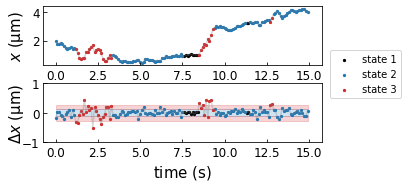

i: 1


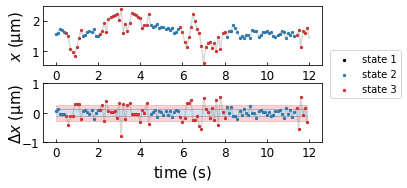

i: 2


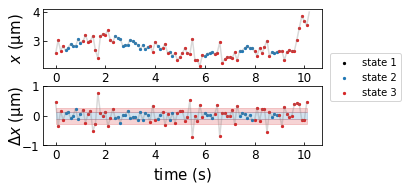

i: 3


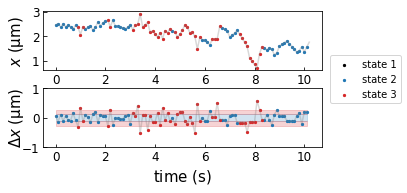

i: 4


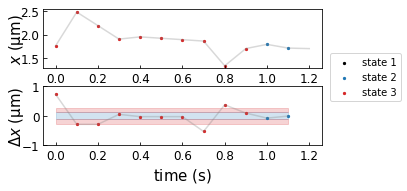

i: 5


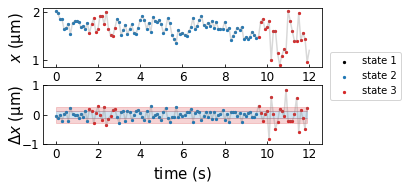

i: 6


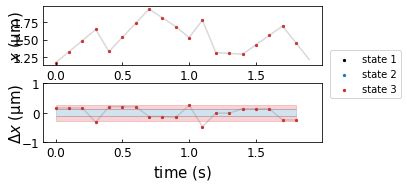

i: 7


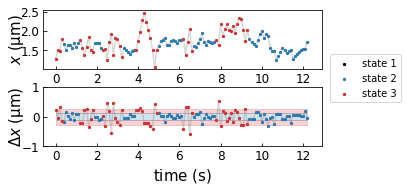

i: 8


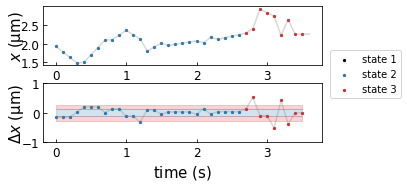

i: 9


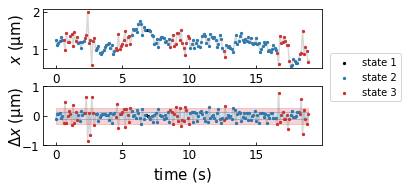

i: 10


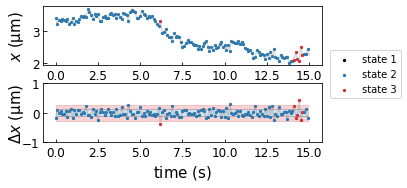

i: 11


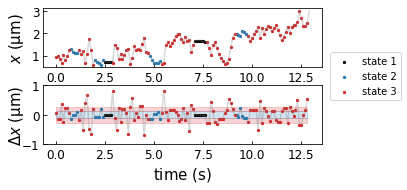

i: 12


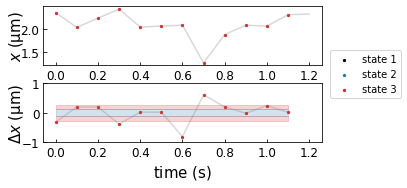

i: 13


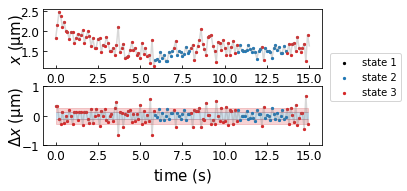

i: 14


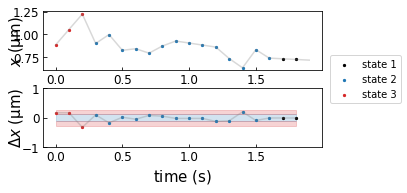

i: 15


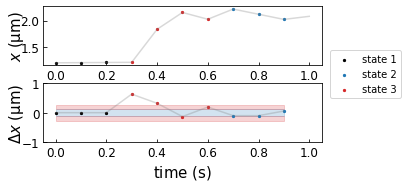

i: 16


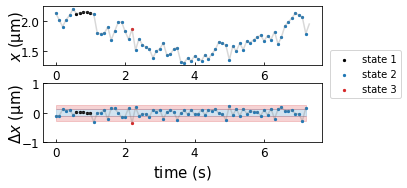

i: 17


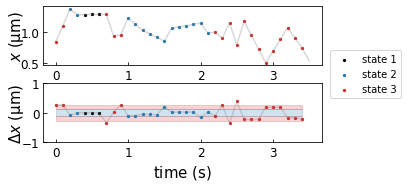

i: 18


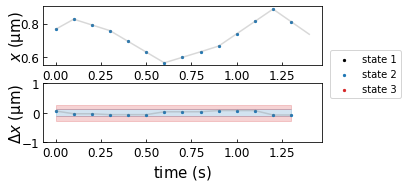

i: 19


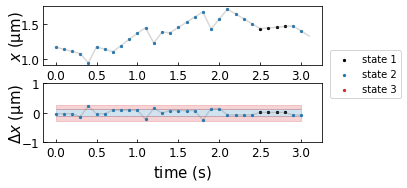

i: 20


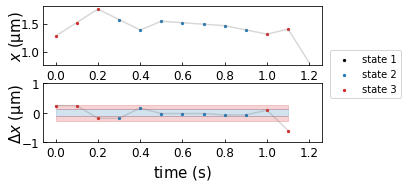

i: 21


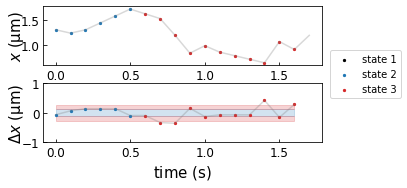

i: 22


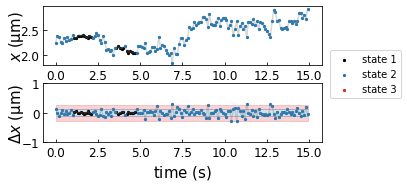

i: 23


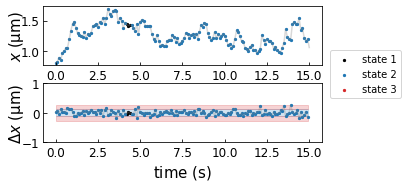

i: 24


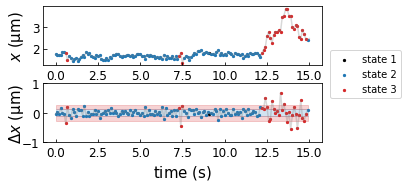

i: 25


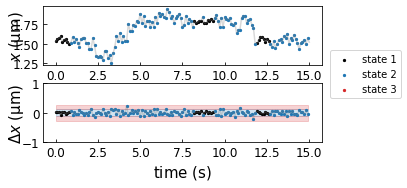

i: 26


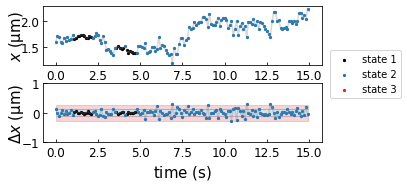

i: 27


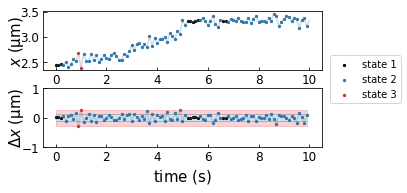

i: 28


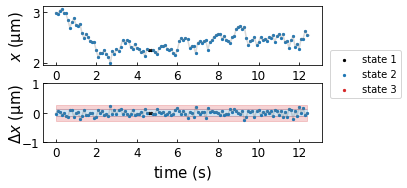

i: 29


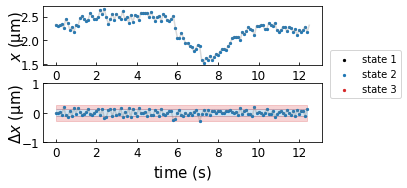

i: 30


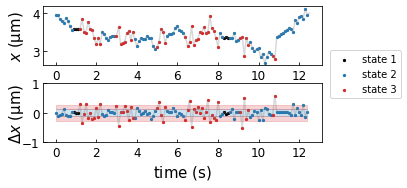

i: 31


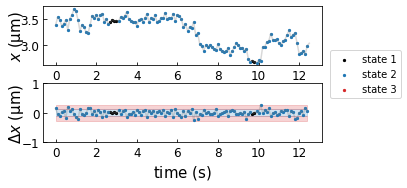

i: 32


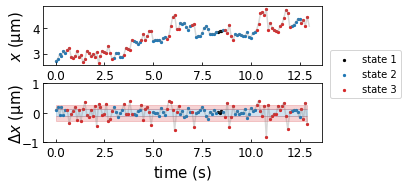

i: 33


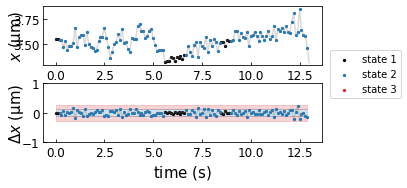

i: 34


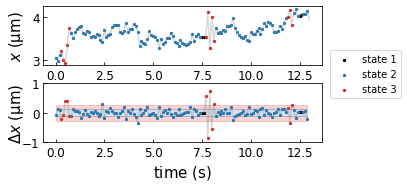

i: 35


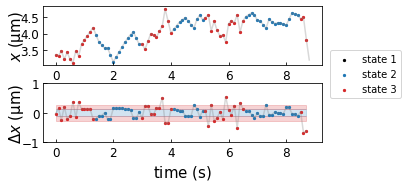

i: 36


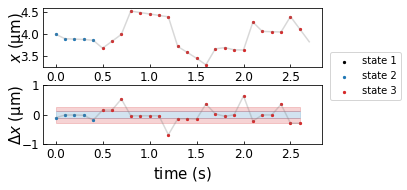

i: 37


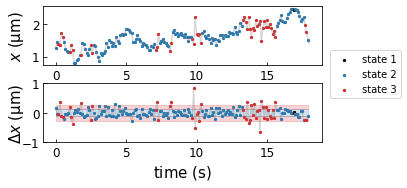

i: 38


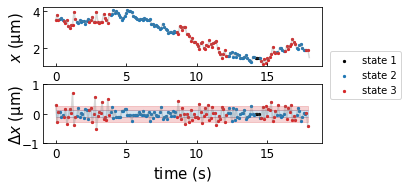

i: 39


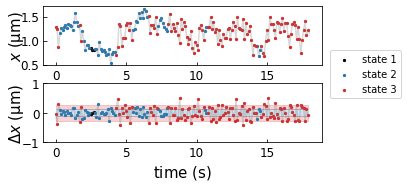

i: 40


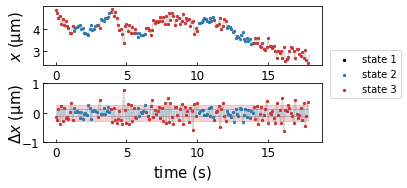

i: 41


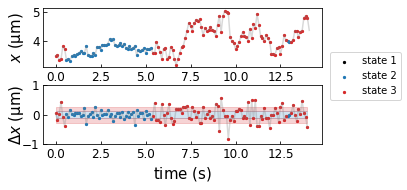

i: 42


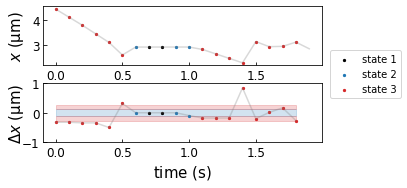

i: 43


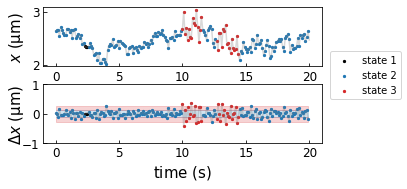

i: 44


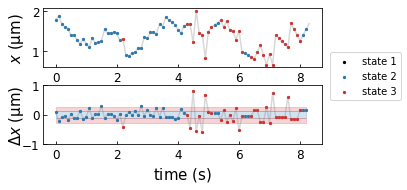

i: 45


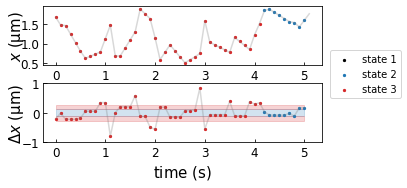

i: 46


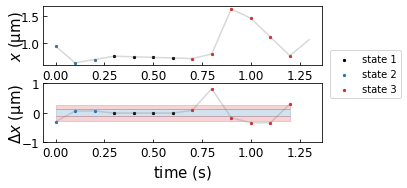

i: 47


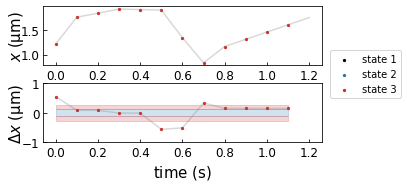

i: 48


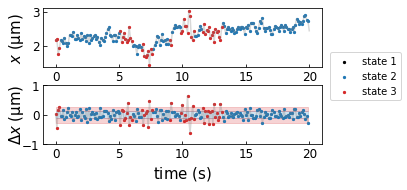

i: 49


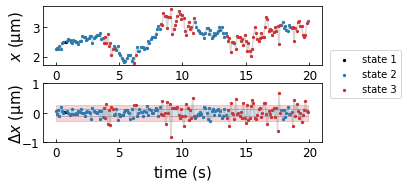

i: 50


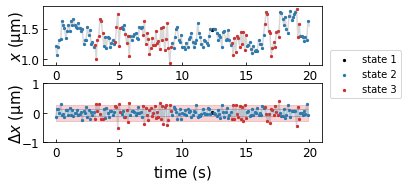

i: 51


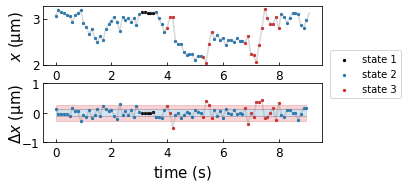

i: 52


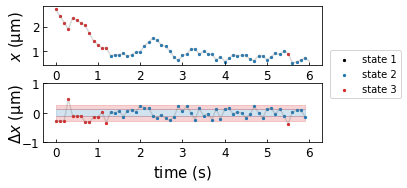

i: 53


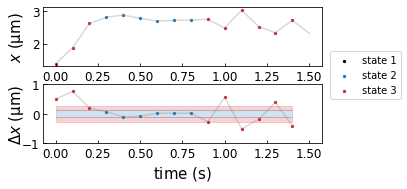

i: 54


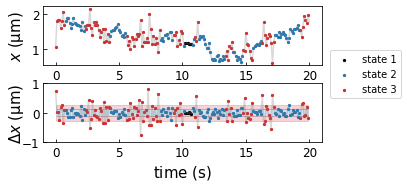

i: 55


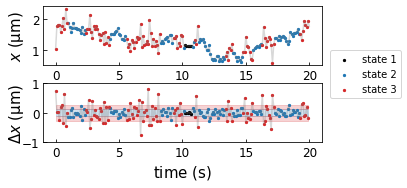

i: 56


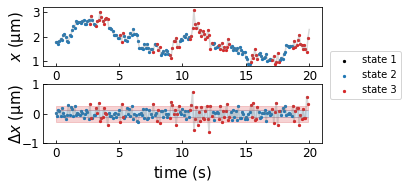

i: 57


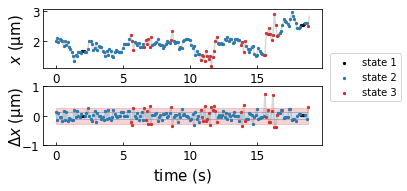

i: 58


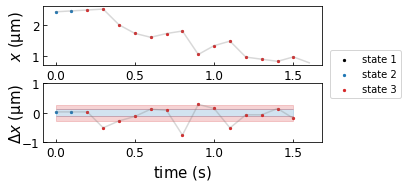

i: 59


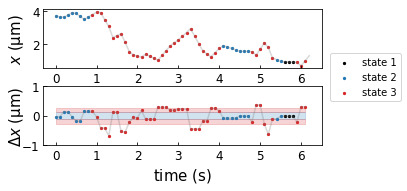

i: 60


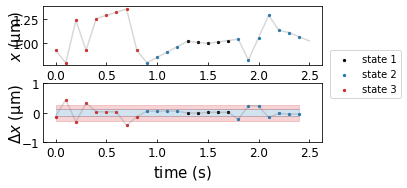

i: 61


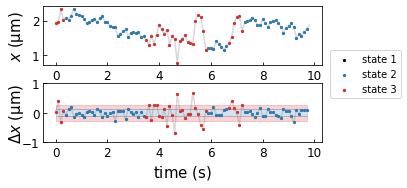

In [14]:
#showcase = [0, 24]
colors = ['k', 'tab:blue', 'tab:red']

for i in range(62):
    print('i:', i)
    fig = plt.figure(figsize=(5, 2.5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    gs = gridspec.GridSpec(nrows=2,
                           ncols=1,
                           height_ratios=[1, 1],
                           width_ratios=[1]
                          )    
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex = ax0)
    
    obs = globals()['{}long{}'.format(protein, i + 1)].copy()
    time = np.arange(len(obs)) * 0.1
    obs_v = np.diff(obs)[:, None]
    est_x = np.argmax(gamma_est(obs_v, P, sigma, 3), axis = 0)
    
    # shade
    ax1.fill_between(time[:len(obs)-1], -widths[1], widths[1], color = 'tab:blue', alpha = 0.2)
    ax1.fill_between(time[:len(obs)-1], -widths[2], -widths[1], color = 'tab:red', alpha = 0.2)
    ax1.fill_between(time[:len(obs)-1], widths[1], widths[2], color = 'tab:red', alpha = 0.2)
    #ax1.fill_between(time[:len(obs)-1], -widths[0], widths[0], where=(est_x == 0), color = 'tab:blue', alpha = 0.2)
    #ax1.fill_between(time[:len(obs)-1], -widths[1], widths[1], where=(est_x == 1), color = 'tab:red', alpha = 0.2)
    # shade
    
    ax1.plot(time[:len(time) - 1], obs_v, c = 'grey', alpha = 0.3)
    for j in range(3):
        ax1.scatter(time[:len(time) - 1][est_x == j], obs_v[est_x == j], c = colors[j], s = 5, label = 'state {}'.format(j+1))

    ax1.set_xlabel(r'time ($\mathrm{s}$)', fontsize = 15)
    ax1.set_ylabel(r'$\Delta x$ ($\mathrm{\mu m}$)', fontsize = 15)
    ax1.tick_params(which = 'both', labelsize = 12, direction = 'in')
    ax1.set_ylim(-1, 1)
    ax1.yaxis.set_label_coords(-0.06, 0.5)
    ax1.legend(loc = 'center right', bbox_to_anchor = (1.3, 1.15))
    
    est_x = np.append(est_x, np.array([-1]))
    
    ax0.plot(time, obs, c = 'grey', alpha = 0.3)
    for j in range(3):
        ax0.scatter(time[est_x == j], obs[est_x == j], c = colors[j], s = 5)
    
#    ax0.set_xlabel(r'time ($\mathrm{s}$)', fontsize = 15)
    ax0.set_ylabel(r'$x$ ($\mathrm{\mu m}$)', fontsize = 15)
    ax0.yaxis.set_label_coords(-0.06, 0.5)
    ax0.tick_params(which = 'both', labelsize = 12, direction = 'in')
    
    #ax0.set_xlim(0, 15)
    
    #plt.savefig('segment{}.pdf'.format(i+1), format = 'pdf', dpi = 1200)
    plt.show()